верно ли, что для любой вершины дерева её ключ
больше всех ключей в левом поддереве данной вершины и
меньше всех ключей в правом поддереве.

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import networkx as nx

class TreeNode:
    def __init__(self):
        self.key = self.num = self.left = self.right = None


def parse_tree(lines):
    if isinstance(lines, str):
        lines = lines.split(';') if lines else []
    tree = [TreeNode() for _ in range(len(lines))]
    for num, line in enumerate(lines):
        if isinstance(line, str):
            key, left, right = map(int, line.strip().split())
        tree[num].num = num
        tree[num].key = key
        if left != -1:
            tree[num].left = tree[left]
        if right != -1:
            tree[num].right = tree[right]
    return tree[0] if tree else None


def draw_tree(tree, root=0,
              width=.07, vgap=.05, vloc=0, xcenter=.5,
              node_color='lightgray', node_size=700,
              **kw):
    if isinstance(tree, str):
        tree = parse_tree(tree)
    if tree is None:
        return

    def add_node(node):
        num = node.num
        if num not in graph.nodes:
            graph.add_node(num)
            labels[num] = str(node.key)
        left = node.left
        if left is not None:
            add_node(left)
            graph.add_edge(num, left.num)
            if not (node.left and node.right):
                labels[left.num] += '<'
        right = node.right
        if right is not None:
            add_node(right)
            graph.add_edge(num, right.num)
            if not (node.left and node.right):
                labels[right.num] += '>'

    graph = nx.Graph()
    labels = {}
    add_node(tree)

    def layout_hier(root, width, vloc, xcenter, pos=None, parent=None):
        if pos is None:
            pos = { root: (xcenter, vloc) }
        else:
            pos[root] = (xcenter, vloc)
        neighbors = list(graph.neighbors(root))
        if parent is not None:
            neighbors.remove(parent)
        if len(neighbors):
            dx = width / len(neighbors) 
            nextx = xcenter - width/2 - dx/2
            for neighbor in neighbors:
                nextx += dx
                pos = layout_hier(neighbor, width=dx, vloc=vloc-vgap, xcenter=nextx,
                                  pos=pos, parent=root)
        return pos

    pos = layout_hier(root, width, vloc, xcenter)
    return nx.draw(graph, pos=pos, with_labels=True, labels=labels,
                   node_color=node_color, node_size=node_size,
                   **kw)

In [2]:
draw_tree('')

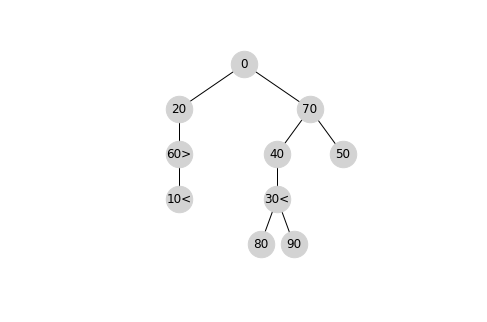

In [3]:
draw_tree('0 7 2;10 -1 -1;20 -1 6;30 8 9;40 3 -1;50 -1 -1;60 1 -1;70 5 4;80 -1 -1;90 -1 -1')

In [4]:
def test_validation(validate):
    tree = parse_tree('')
    assert validate(tree) == True

    tree = parse_tree('2 1 2;1 -1 -1;3 -1 -1')
    assert validate(tree) == True

    tree = parse_tree('1 1 2;2 -1 -1;3 -1 -1')
    assert validate(tree) == False

    print('ok')

In [5]:
def validate_recur_postorder(root):
    def recurse(node):
        cur_val = cur_min = cur_max = node.key
        if node.left:
            left_min, left_max = recurse(node.left)
            assert cur_val > left_max
            cur_min = min(cur_min, left_min)
            cur_max = max(cur_max, left_max)
        if node.right:
            right_min, right_max = recurse(node.right)
            assert cur_val < right_min
            cur_min = min(cur_min, right_min)
            cur_max = max(cur_max, right_max)
        return cur_min, cur_max
    try:
        if root:
            recurse(root)
        return True
    except AssertionError:
        return False

test_validation(validate_recur_postorder)

ok


In [6]:
def validate_recur_inorder(root):
    curval = None
    def recurse(node):
        if node.left:
            recurse(node.left)
        nonlocal curval
        if curval is not None:
            assert node.key > curval
        curval = node.key
        if node.right:
            recurse(node.right)
    try:
        if root:
            recurse(root)
        return True
    except AssertionError:
        return False

test_validation(validate_recur_inorder)

ok


In [7]:
def validate_iter_inorder(node):
    oldval = None
    stack = []
    while node or stack:
        if node:
            stack.append(node)
            node = node.left
            continue
        node = stack.pop()
        curval = node.key
        node = node.right
        if oldval is not None and curval <= oldval:
            return False
        oldval = curval
    return True

test_validation(validate_iter_inorder)

ok


In [8]:
%%writefile tree-validity-rec.py
################################
# like exam, but recirsive

from collections import namedtuple

TupleNode = namedtuple('TupleNode', ['key', 'left', 'right'])

def validate_rec(tree, node=0):
    cur_val = cur_min = cur_max = tree[node].key
    left = tree[node].left
    if left >= 0:
        left_min, left_max = validate_rec(tree, left)
        assert cur_val > left_max
        cur_min = min(cur_min, left_min)
        cur_max = max(cur_max, left_max)
    right = tree[node].right
    if right >= 0:
        right_min, right_max = validate_rec(tree, right)
        assert cur_val < right_min
        cur_min = min(cur_min, right_min)
        cur_max = max(cur_max, right_max)
    return cur_min, cur_max

def main():
    num_nodes = int(input())
    tree = [TupleNode(*map(int, input().split()))
            for i in range(num_nodes)]
    try:
        if tree:
            validate_rec(tree)
        print('CORRECT')
    except AssertionError:
        print('INCORRECT')

if __name__ == '__main__':
    import sys
    sys.setrecursionlimit(65536)
    main()

Writing tree-validity-rec.py


In [9]:
%%bash
python3 tree-validity-rec.py <<EOF
3
2 1 2
1 -1 -1
3 -1 -1
EOF
# expect: CORRECT

CORRECT


In [10]:
%%bash
python3 tree-validity-rec.py <<EOF
3
1 1 2
2 -1 -1
3 -1 -1
EOF
# expect: INCORRECT

INCORRECT


In [11]:
%%bash
python3 tree-validity-rec.py <<EOF
0
EOF
# expect: CORRECT

CORRECT


In [12]:
%%writefile tree-validity-seq.py
#########
# exam

from collections import namedtuple


def validate_seq():
    node, stack, oldval = 0, [], None
    while tree and node >= 0 or stack:
        if node >= 0:
            stack.append(node)
            node = tree[node].left
            continue
        node = stack.pop()
        curval = tree[node].key
        node = tree[node].right
        if oldval is not None and curval <= oldval:
            return False
        oldval = curval
    return True


num_nodes = int(input())
TupleNode = namedtuple('TupleNode', ['key', 'left', 'right'])
tree = [TupleNode(*map(int, input().split())) for _ in range(num_nodes)]
print(['INCORRECT', 'CORRECT'][validate_seq()])


Writing tree-validity-seq.py


In [13]:
%%bash
python3 tree-validity-seq.py <<EOF
3
2 1 2
1 -1 -1
3 -1 -1
EOF
# expect: CORRECT

CORRECT


In [14]:
%%bash
python3 tree-validity-seq.py <<EOF
3
1 1 2
2 -1 -1
3 -1 -1
EOF
# expect: INCORRECT

INCORRECT


In [15]:
%%bash
python3 tree-validity-seq.py <<EOF
0
EOF
# expect: CORRECT

CORRECT
